Liliana Djaja Witama\
2702219774

# UAS Deep Learning
## No 2 - Dataset A_23

**Link video:** https://drive.google.com/file/d/1BoN-jRP0jYgbo41dKMjk3dDUMwdIxvLy/view?usp=sharing

## import libraries

In [ ]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from skimage.metrics import structural_similarity as ssim
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow import keras
import keras_tuner as kt

import random
SEED_VALUE=42
random.seed(SEED_VALUE)
np.random.seed(SEED_VALUE)

## import dataset

In [37]:
from google.colab import drive
drive.mount('/content/drive')

image_folder = "/content/drive/MyDrive/uas deep learning/no 2/A_23"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [38]:
def load_images(folder_path):
    image_arrays = []
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]

    for fname in image_files:
        img_path = os.path.join(folder_path, fname)
        img = Image.open(img_path)
        image_arrays.append(img)

    return image_arrays, image_files


loaded_images, file_names = load_images(image_folder)

## EDA

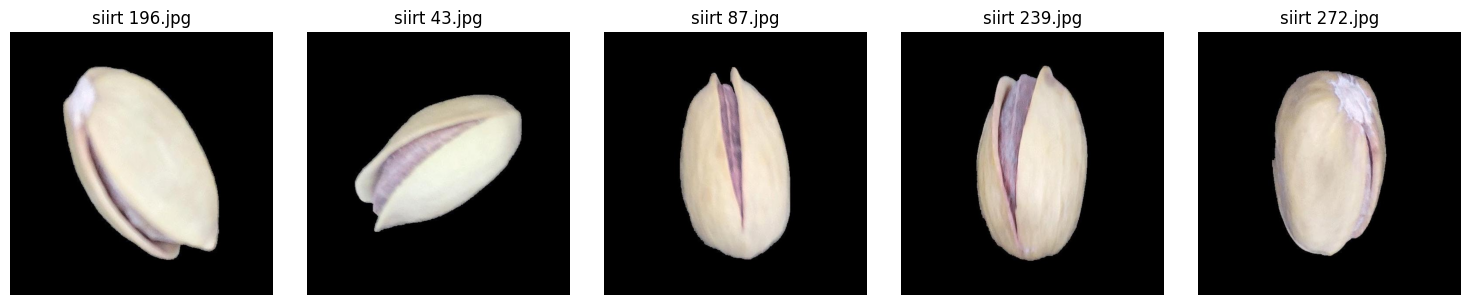

In [39]:
def show_images(images, file_names, n=5):
    plt.figure(figsize=(15, 3))
    for i in range(min(n, len(images))):
        plt.subplot(1, n, i+1)
        plt.imshow(images[i])
        plt.title(file_names[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

show_images(loaded_images, file_names, n=5)

melihat 5 contoh gambar untuk mengetahui data aktual

### aspect ratio

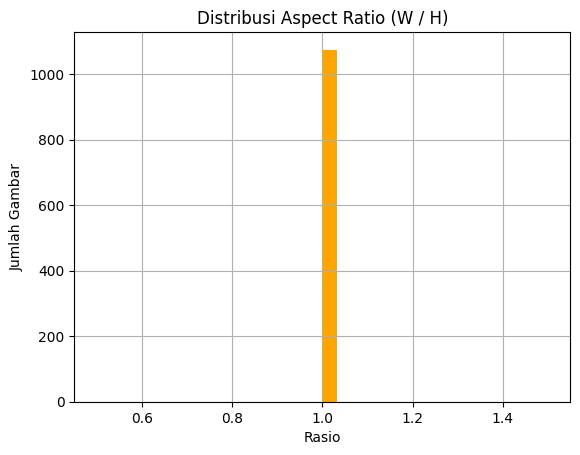

In [40]:
aspect_ratios = []

for img in loaded_images:
    w, h = img.size
    if h > 0:
        aspect_ratios.append(round(w / h, 2))

plt.hist(aspect_ratios, bins=30, color='orange')
plt.title("Distribusi Aspect Ratio (W / H)")
plt.xlabel("Rasio")
plt.ylabel("Jumlah Gambar")
plt.grid(True)
plt.show()

Melihat aspect ration untuk mengetahui distribusi bentuk gambar dalam dataset (landscape/portrait) dan apakah terdapat rasio yang terlau ekstrem (terlalu lebar/tinggi).

Dari grafik tersebut dapat diketahui bahwa semua gambar memiliki rasio mendekati 1.0 (persegi).

### distribusi resolusi

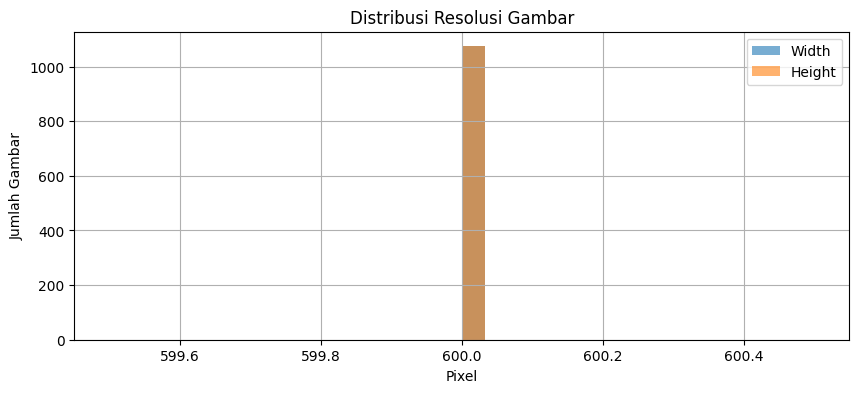

In [41]:
widths, heights = [], []

for img in loaded_images:
    w, h = img.size
    widths.append(w)
    heights.append(h)

plt.figure(figsize=(10, 4))
plt.hist(widths, bins=30, alpha=0.6, label='Width')
plt.hist(heights, bins=30, alpha=0.6, label='Height')
plt.title("Distribusi Resolusi Gambar")
plt.xlabel("Pixel")
plt.ylabel("Jumlah Gambar")
plt.legend()
plt.grid(True)
plt.show()

Melihat distribusi resolusi gambar untuk mengetahui ukuran gambar dalam dataset untuk menilai variasi resolusi dan untuk mengidentifikasi gambar dengan resolusi tidak standar yang mungkin memerlukan preprocessing khusus.

Dari grafik dapat diketahui bahwa semua gambar dalam datset memiliki resolusi yang seragam yaitu di 600x600 pixel.

### resize dan normalisasi

In [ ]:
def resize_and_normalize(images, target_size=(100, 100)):
    processed = []
    for img in images:
        img_resized = img.resize(target_size)
        arr = np.array(img_resized) / 255.0
        processed.append(arr)
    return np.array(processed)

image_array = resize_and_normalize(loaded_images)

### distribusi nilai pixel

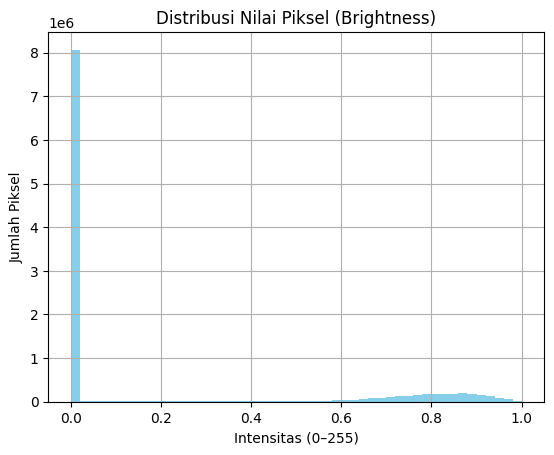

In [ ]:
all_pixels = []

for arr in image_array:
    if arr.ndim == 3:
        arr = arr.mean(axis=2)
    all_pixels.extend(arr.flatten())

plt.hist(all_pixels, bins=50, color='skyblue')
plt.title("Distribusi Nilai Piksel (Brightness)")
plt.xlabel("Intensitas (0–255)")
plt.ylabel("Jumlah Piksel")
plt.grid(True)
plt.show()

Melihat distribusi brightness untuk mengidentifikasi masalah seperti over/underexposure (terlalu terang/gelap) atau low contrast dan melihat apakah dataset memiliki variasi pencahayaan yang memadai untuk melatih model yang robust.

Dari grafik bisa terlihat bahwa ada distribusi yang simetris dengan puncak berada di intensitas menengah (+-0.5) dengan ekor ke 0 (gelap) dan 1 (terang). Ini menunjukkan variasi pencahayaan yang seimbang. Puncak di dekat 0 menandakan bahwa terdapat banyak piksel gelap (underexposed).

## Preprocessing

### split (80% training, 10% validasi dan 10% testing)

In [44]:
X_trainval, X_test = train_test_split(image_array, test_size=0.1, random_state=SEED_VALUE)
X_train, X_val = train_test_split(X_trainval, test_size=0.1111, random_state=SEED_VALUE)

In [45]:
y_train = X_train.copy()
y_val = X_val.copy()
y_test = X_test.copy()

copy X ke y untuk menghindari modifikasi tidak sengaja pada data asli (X) ketika memproses y

### tambah noise
noise nilai acak yang diambil dari distribusi normal (Gaussian), menggunakan rata-rata 0.0 dan standard deviasi 0.1

In [46]:
def add_noise(data, mean=0.0, std=0.1):
    noise = np.random.normal(loc=mean, scale=std, size=data.shape)
    return np.clip(data + noise, 0., 1.)

X_train_noisy = add_noise(X_train)
X_val_noisy = add_noise(X_val)
X_test_noisy = add_noise(X_test)

## modelling

### Baseline model

In [ ]:
def build_model_baseline():
    input_img = layers.Input(shape=(100, 100, 3))

    #encoder
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)

    #bottleneck
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)

    #decoder
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = models.Model(inputs=input_img, outputs=decoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder


model_baseline = build_model_baseline()
model_baseline.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 100, 100, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 50, 50, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 25, 25, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 50, 50, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_3 (UpSampling2D)  │ (None, 100, 100, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 100, 100, 3)    │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,651 (295.51 KB)

 Trainable params: 75,651 (295.51 KB)

 Non-trainable params: 0 (0.00 B)

Model ini terdiri dari 3 bagian:
1. Encoder\
Mengurangi dimensi gambar sambil mengekstrak fitur penting.\
Input: 100x100x3\
Output: 25x25x64

2. Bottleneck\
Menyimpan representasi terkompresi dari gambar asli.\
Input: 25x25x64\
Output: 25x25x64

3. Decoder\
Memperbesar kembali dimensi dari bottleneck ke ukuran asli.\
Input: 25x25x64\
Output: 100x100x3

In [48]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint("model_baseline.keras", save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
]

Diberikan callbacks untuk optimasi training yang akan menghentikan pelatihan jika val_loss tidak membaik dalam 5 epoch (EarlyStopping), menyimpan model terbaik (save_best_only=True) ke file model_baseline.keras (ModelCheckpoint), dan mengurangi learning rate (×0.5) jika val_loss tidak membaik dalam 5 epoch (ReduceLROnPlateau).

In [49]:
history_model_baseline = model_baseline.fit(X_train, y_train,
                        epochs=30,
                        batch_size=32,
                        shuffle=True,
                        validation_data=(X_val, y_val),
                        callbacks=callbacks)

Epoch 1/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - loss: 0.1509 - val_loss: 0.0127 - learning_rate: 0.0010
Epoch 2/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0134 - val_loss: 0.0132 - learning_rate: 0.0010
Epoch 3/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0272 - val_loss: 0.0141 - learning_rate: 0.0010
Epoch 4/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0146 - val_loss: 0.0128 - learning_rate: 0.0010
Epoch 5/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0134 - val_loss: 0.0123 - learning_rate: 5.0000e-04
Epoch 6/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0131 - val_loss: 0.0117 - learning_rate: 5.0000e-04
Epoch 7/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0121 - val_loss: 0.0098 - learning_rate: 5.0000e-04
Epoch 8/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0082 - val_loss: 0.0037 - learning_rate: 5.0000e-04
Epoch 9/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0038 - val_loss: 0.0033 - learning_rate: 5.0000e-04


Training dilakukan dengan 30 epochs dan batch_size 32, dengan callbacks yang sudah dirincikan di atas.

Hasil training:
- Ada gap besar antara loss training dan validation di awal, menunjukkan model mungkin overfit pada data training awal.
- Loss turun drastis setelah Epoch 1 (dari 0.1509 ke 0.0134 di Epoch 2). Ini berarti model belajar sangat cepat di awal, lalu konvergen secara stabil.
- Pada epoch 30, loss dan val_loss yang keduanya berada di angka 0.0010.
- Learning rate epoch 1-4 ada di 0.001, kemudian diturunkan setangahnya menjadi 0.0005 di epoch 5-30.

Kesimpulan:\
Model berhasil mencapai konvergensi dengan error yang sangat rendah dan generalizes well.

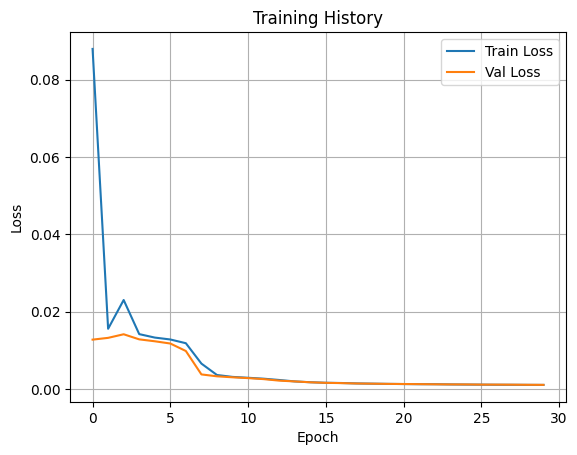

In [50]:
plt.plot(history_model_baseline.history['loss'], label='Train Loss')
plt.plot(history_model_baseline.history['val_loss'], label='Val Loss')
plt.title("Training History")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

- Train Loss & Val Loss menurun stabil, menunjukkan model belajar dengan baik.
- Tidak ada overfitting (gap antara train dan val loss kecil).
- Konvergensi tercapai di akhir training (loss mendekati 0.00).

### Modified model

In [53]:
!pip install keras-tuner --quiet

In [ ]:
def model_tuning(hp):
    input_img = layers.Input(shape=(100, 100, 3))

    filters_1 = hp.Choice('filters_1', [16, 32, 64])
    filters_2 = hp.Choice('filters_2', [32, 64, 128])
    activation = hp.Choice('activation', ['relu', 'leaky_relu'])

    # Encoder
    x = layers.Conv2D(filters_1, (3, 3), padding='same')(input_img)
    x = layers.Activation(activation)(x) if activation != 'leaky_relu' else layers.LeakyReLU()(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)

    x = layers.Conv2D(filters_2, (3, 3), padding='same')(x)
    x = layers.Activation(activation)(x) if activation != 'leaky_relu' else layers.LeakyReLU()(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)

    # Bottleneck
    x = layers.Conv2D(filters_2, (3, 3), activation=activation, padding='same')(x)

    # Decoder
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(filters_1, (3, 3), activation=activation, padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    model = models.Model(inputs=input_img, outputs=decoded)

    lr = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr), loss='mse')

    return model

Tuning dilakukan menggunakan Keras Tuner. Arsitektur model disamakan dengan model baseline dan saya hanya melakukan tuning terhadap hyperparameternya.

Beberapa parameter yang di-tuning yaitu:
- filters_1 dituning dengan search space [16, 32, 64] untuk menyeimbangkan kompleksitas model dan kapasitas ekstraksi fitur
- filters_2	dituning dengan search space [32, 64, 128] untuk meningkatkan kedalaman fitur di bottleneck
- activation dituning dengan search space ['relu', 'leaky_relu'] untuk mengatasi masalah vanishing gradient
- learning_rate dituning dengan search space [1e-2, 1e-3, 1e-4] untuk mengontrol kecepatan dan stabilitas pembelajaran

In [ ]:
tuner = kt.RandomSearch(
    model_tuning,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    directory='tuner_dir',
    project_name='autoencoder_denoising'
)

Reloading Tuner from tuner_dir/autoencoder_denoising/tuner0.json


Menggunakan RandomSearch untuk mencari kombinasi hyperparameter terbaik untuk model secara random dari search space yang sudah ditentukan sebelumnya, dengan total trials sebanyak 10 trials

In [56]:
tuner.search(X_train_noisy, y_train,
             epochs=20,
             validation_data=(X_val_noisy, y_val),
             callbacks=[
                 keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
             ])

Melakukan hyperparameter tuning dengan 20 epochs, ditambah dengan callback EarlyStopping yang akan stop training jika tidak ada improvement pada val_loss selama 3 epochs berturut-turut.

In [57]:
best_hp = tuner.get_best_hyperparameters(1)[0]
print("Best config:")
print(f"filters_1: {best_hp.get('filters_1')}")
print(f"filters_2: {best_hp.get('filters_2')}")
print(f"activation: {best_hp.get('activation')}")
print(f"learning_rate: {best_hp.get('learning_rate')}")

best_model = tuner.get_best_models(1)[0]

Best config:
filters_1: 16
filters_2: 128
activation: relu
learning_rate: 0.01


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


best_hp mengambil hyperparameter terbaik dan konfigurasi terbaiknya yaitu:\
- filters_1: 16
- filters_2: 128
- activation: relu
- learning_rate: 0.01

In [58]:
history_tuned = best_model.fit(X_train_noisy, y_train,
                         epochs=30,
                         validation_data=(X_val_noisy, y_val),
                         callbacks=[keras.callbacks.EarlyStopping(patience=5)])

Epoch 1/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - loss: 0.0156 - val_loss: 0.0027
Epoch 2/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0024 - val_loss: 0.0021
Epoch 3/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0020 - val_loss: 0.0017
Epoch 4/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0016 - val_loss: 0.0013
Epoch 5/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 6/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 7/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0012 - val_loss: 0.0014
Epoch 8/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0012 - val_loss: 0.0010
Epoch 9/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 10/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 11/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0011 - val_loss: 9.6431e-04
Epoch 12/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 9.597

Melakukan training ulang menggunakan hyperparameter terbaik dengan 30 epochs.

Hasil training:
- Terdapat gap besar di awal (train=0.0156 dan val=0.0027)
- Pada epoch 4, loss sudah turun drastis (train=0.0016, val=0.0013), yang berarti model belajar pola denoising dengan sangat efektif dalam waktu singkat
- Setelah epoch 10, kedua loss berkisar di 0.0007-0.0011 dengan fluktuasi yang minimal
- Pada akhir epoch, selisih loss dan val_loss hanya sebesar 0.0002 yang menandakan tidak adanya overfitting

Kesimpulan:\
Model memiliki performa sangat tinggi, stabil, dan dapat melakukan generalisasi yang sempurna

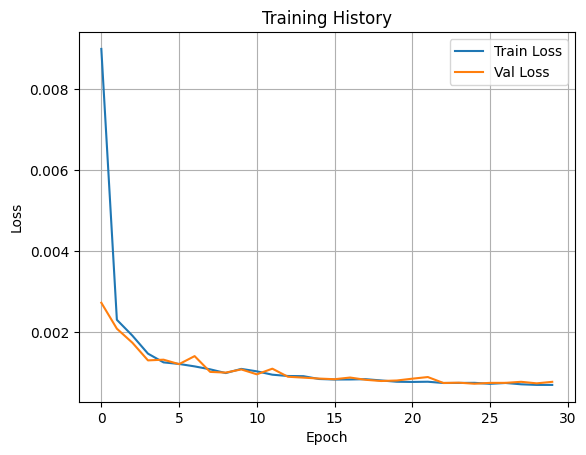

In [59]:
plt.plot(history_tuned.history['loss'], label='Train Loss')
plt.plot(history_tuned.history['val_loss'], label='Val Loss')
plt.title("Training History")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

Dari grafik bisa dilihat bahwa training loss dan val loss menurun stabil dari epoch awal hingga akhir yang menunjukkan model belajar efektif. Jarak antara train loss dan val loss yang konsisten kecil mengindikasikan generalisasi yang baik sehingga tidak terjadi overfitting.

## Evaluasi (SSIM)

In [ ]:
def evaluate_ssim(model, x_data, y_true):
    y_pred = model.predict(x_data)
    scores = []

    for i in range(len(y_true)):
        s = ssim(y_true[i], y_pred[i], channel_axis=-1, data_range=1.0)
        scores.append(s)

    return np.mean(scores)

SSIM membandingkan setiap  gambar hasil reonstruksi (y_pred) dengan gambar asli (y_true). Kemudian, skor SSIM semua gambar dirata-rata. SSIM cocok untuk mengevaluasi autoencoder karena SSIM bisa mengevaluasi struktur gambar penting, misalnya edges, dan menilai apakah struktur itu berhasil direkonstruksi.

### Baseline model

In [ ]:
ssim_score = evaluate_ssim(model_baseline, X_test_noisy, y_test)
print(f"Average SSIM on Test Set: {ssim_score:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step
Average SSIM on Test Set: 0.8981


SSIM = 0.8981 berarti gambar hasil rekonstruksi memiliki 89.81% kemiripan struktural dengan gambar asli. Detail penting (edges, tekstur) sudah tertangkap dengan baik, tapi mungkin ada sedikit blur pada area kompleks dan warna/contrast sedikit berbeda.

### Modified model

In [ ]:
ssim_score = evaluate_ssim(best_model, X_test_noisy, y_test)
print(f"Average SSIM on Test Set: {ssim_score:.4f}")

1/4 ━━━━━━━━━━━━━━━━━━━━ 1s 374ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step
Average SSIM on Test Set: 0.9581


SSIM = 0.9581 berarti rekonstruksi gambar hampir sempurna dengan 95.81% kemiripan struktural. Perbedaan visual juga hampir tidak terlihat oleh mata. Model hasil tuning menunjukkan hasil yang lebih baik dibandingkan dengan model baseline.

### Denoising output

In [ ]:
def show_denoising_result(model, x_input, y_true, n=5):
    y_pred = model.predict(x_input)

    plt.figure(figsize=(15, 5))
    for i in range(n):
        plt.subplot(3, n, i + 1)
        plt.imshow(x_input[i])
        plt.title("Noisy")
        plt.axis('off')

        plt.subplot(3, n, i + 1 + n)
        plt.imshow(y_pred[i])
        plt.title("Denoised")
        plt.axis('off')

        plt.subplot(3, n, i + 1 + 2 * n)
        plt.imshow(y_true[i])
        plt.title("Original")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


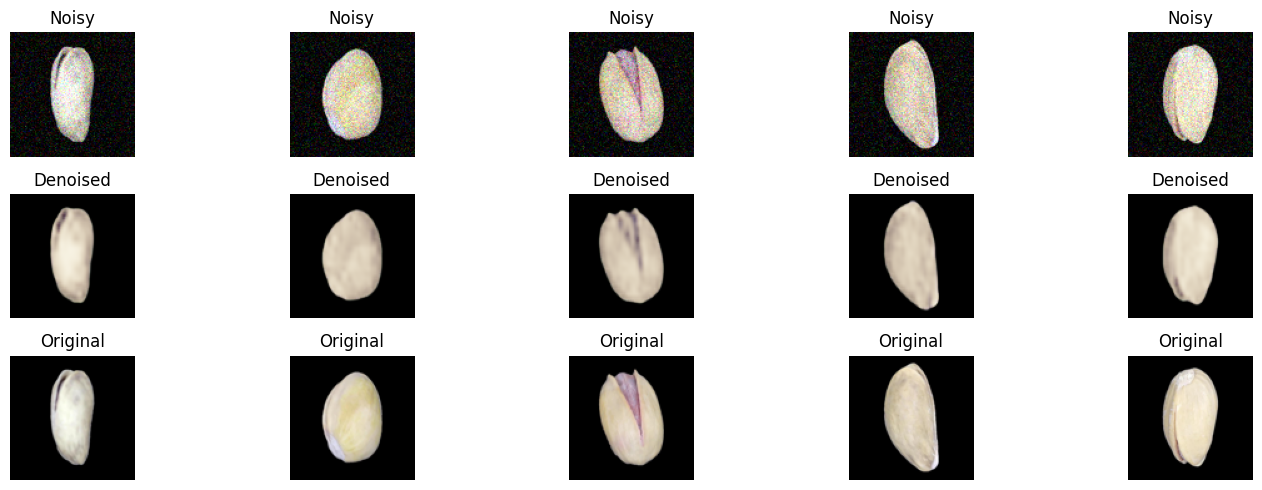

In [62]:
show_denoising_result(best_model, X_test_noisy, y_test, n=5)

Jika dilihat dari gambar hasil rekonstruksi (Denoised), bisa dilihat bahwa mayoritas noise berhasil dihilangkan. Gambar rekonstruksi juga sudah mirip dengan yang original, tetapi mungkin ada area yang masih terlihat terlalu gelap.

## Kesimpulan
Model hasil tuning menunjukkan hasil yang lebih baik dibandingkan dengan model baseline dengan skor SSIM sebesar 0.9581. Jika ditinjau dari gambar rekonstruksi, hasilnya mirip dengan asli dengan perbedaan yang minimal.